<a href="https://colab.research.google.com/github/pmontman/pub-choicemodels/blob/main/nb/solution/solu_tuto_07_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 7 Machine Learning models

In this tutorial, we will revisit the 'recreational fishing' dataset to compare the logit family to some machine learning models that can be used for predicting choices.

We will learn
 * How to estimate some of the more popular machine learning models
 * How to evaluate them

We will start by specifying some logit models, repeating the code from previous tutorials, and then we jump into the machine learning models.

We will do holdout validation, the new parts of the tutorial start in section 'Splitting the dataset into train and test sets'.


The reference study for the recreational fishing, including a more detailed description of the dataset can be found [here](https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=1017&context=econ_las_pubs)


# Description of the dataset



Each row represents a different customer, customers are 'independent' of each other.

The variables in the dataset are:

**mode**: a categorical variable indicating the fishing model selected for the trip. It is encoded in numbers, with the code:
 1. Beach
 2. Pier
 3. Private boat
 4. Charter boat

**price_x**:  Cost of the fishing mode, variable in dollars. Where x stands for one of the alternatives, e.g. price_beach is the cost of the fishing from the beach in one fishing trip.

**catch_x**: Catch rate, in catches per hour. Where x stands for one of the alternatives, e.g. catch_beach is the catch rate of the beach alternative.

**income**: Monthly income of the recreational fisher, in dollars.


---
---

# Preparing the environment
*The preparation and dataset loading code is given to the students*

In [1]:
!pip install biogeme

     |████████████████████████████████| 1.5 MB 12.8 MB/s 
     |████████████████████████████████| 235 kB 43.9 MB/s 
  Created wheel for biogeme: filename=biogeme-3.2.8-cp37-cp37m-linux_x86_64.whl size=4030664 sha256=de41f3313269418af146f263f2e3cb044f17880a29ab1468e42d1986c464c773
  Stored in directory: /root/.cache/pip/wheels/d4/52/61/de6c73d2bc17603c60e754e260bccb7d4da2503e97015ebd49
Successfully built biogeme


Load the packages, feel free to change the names.

In [2]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.expressions as exp
import biogeme.tools as tools

# Load the dataset

In [3]:
path = 'https://raw.githubusercontent.com/pmontman/pub-choicemodels/main/data/fishing.csv'
fish_pd = pd.read_csv(path)

A simple look at the dataset.

In [4]:
fish_pd.head(5)

,mode,price_beach,price_pier,price_boat,price_charter,catch_beach,catch_pier,catch_boat,catch_charter,income
0,4,157.930,157.930,157.930,182.930,0.0678,0.0503,0.2601,0.5391,7083.3317
1,4,15.114,15.114,10.534,34.534,0.1049,0.0451,0.1574,0.4671,1249.9998
2,3,161.874,161.874,24.334,59.334,0.5333,0.4522,0.2413,1.0266,3749.9999
3,2,15.134,15.134,55.930,84.930,0.0678,0.0789,0.1643,0.5391,2083.3332
4,3,106.930,106.930,41.514,71.014,0.0678,0.0503,0.1082,0.3240,4583.3320


---
---

# Auxiliary functions

The first function takes the dictionary of utilities, a pandas dataframe, and the name of the variable that contains the variable with the results of the choice. It returns the biogeme object with the model and the estimated 'results' object (the one we get the values, likelihoods, etc.)
We have added the dictionary with the utilities to the biogeme object, in case we use it later.

In [5]:
def qbus_estimate_bgm(V, pd_df, tgtvar_name, modelname='bgmdef'):
 av_auto = V.copy()
 for key, value in av_auto.items():
   av_auto[key] = 1
 bgm_db = db.Database(modelname + '_db', pd_df)
 globals().update(bgm_db.variables)
 logprob = models.loglogit (V , av_auto , bgm_db.variables[tgtvar_name] )
 bgm_model = bio.BIOGEME ( bgm_db, logprob )
 bgm_model.utility_dic = V.copy()
 return bgm_model, bgm_model.estimate()

The next function will calculate the predictions for a given biogeme object that was estimated with `qbus_estimate_bgm`. The output is the array with the choice probabilities. From the choice probabilities, this can be used to calculate accuracies, confusion matrices and the output of what-if scenarios.

In [6]:
def qbus_simulate_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

  targets = qbus_bgm_model.utility_dic.copy()
  for key, value in targets.items():
   targets[key] = models.logit(qbus_bgm_model.utility_dic, av_auto, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, targets)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

The function `qbus_calc_accu_confusion` calculates the accuracies given the choice probability predictions a pandas dataset and the specification of the name that contains the actual choices in the input dataset.

In [7]:
def qbus_calc_accu_confusion(sim_probs, pd_df, choice_var):
  which_max = sim_probs.idxmax(axis=1)
  data = {'y_Actual':   pd_df[choice_var],
          'y_Predicted': which_max
        }

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
  accu = np.mean(which_max == pd_df[choice_var])
  return accu, confusion_matrix 

The next function calculates the likelihood ratio test having to write a bit less code that the default biogeme function. The arguments are the results objects of the two models to be compared. The first is the more complex and the second is the reference model (**the order is important!**). The third argument is the significance level for the test.

In [8]:
def qbus_likeli_ratio_test_bgm(results_complex, results_reference, signif_level):
  return tools.likelihood_ratio_test( (results_complex.data.logLike, results_complex.data.nparam),
                                     (results_reference.data.logLike, results_reference.data.nparam), signif_level)

The next function just updates the globals so we can use it 

In [9]:
def qbus_update_globals_bgm(pd_df):
   globals().update(db.Database('tmp_bg_bgm_for_glob', pd_df).variables)

# Splitting the dataset into train and test tests

We will apply the holdout technique for validating and comparing models. This consists of splitting the dataset into two parts, often called train and test sets. The train set is used to estimate the models, and the test set is used to validate the models. The split is often required because very complex models are often able to approximate the observed data very well, but they do not generalize well, the do not work well in unseen data. Validation techinques such as the log-likelihood comparison can theoretically work, but they are less reliable when models are very complex.

Likelihood ratio tests often fail on the side of being too conservative, meaning that they will prefer simple methods when a more complex method would do better.

In the following cell, we use a function from the `sklearn` package to split the dataset. The arguments for the function `train_test_split` are the dataset, the ratio of the split (75% of the samples go to the train set, 25% to the test set) and a random seed so the random split can be reproduced exactly the next time we run the notebook.

We split the fish dataset into `fish_train` and `fish_test`

In [10]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
fish_train, fish_test = train_test_split(fish_pd, test_size = 0.25, random_state = 3840)

We check quickly the results of the split, we see that they look like the split was successful.

In [11]:
fish_train.head()

,mode,price_beach,price_pier,price_boat,price_charter,catch_beach,catch_pier,catch_boat,catch_charter,income
997,1,17.496,17.496,247.860,282.860,0.5333,0.4522,0.2413,1.0266,5416.6667
1123,1,9.290,9.290,287.990,322.990,0.5333,0.4522,0.2413,1.0266,7083.3317
589,4,157.872,157.872,10.296,45.296,0.5333,0.4522,0.1665,0.3975,2916.6666
1040,3,39.846,39.846,6.870,31.870,0.2537,0.1498,0.6817,2.3014,1249.9998
275,2,2.290,2.290,2.290,31.290,0.0678,0.0789,0.0971,0.1648,1249.9998


In [12]:
fish_test.head()

,mode,price_beach,price_pier,price_boat,price_charter,catch_beach,catch_pier,catch_boat,catch_charter,income
651,4,231.472,231.472,15.096,50.096,0.5333,0.4522,0.1665,0.3975,4583.3320
699,3,252.016,252.016,24.870,54.370,0.0678,0.0503,0.0143,0.0289,6250.0013
1122,1,6.290,6.290,194.990,229.990,0.5333,0.4522,0.1665,0.3975,4583.3320
831,4,116.994,116.994,18.870,53.870,0.0678,0.0789,0.0897,1.0905,4583.3320
429,4,191.334,191.334,64.350,99.350,0.5333,0.4522,0.1665,0.3975,2916.6666


---
---

# Estimating the models from previous tutorial, just to get them as reference

In [13]:
ASC_beach = exp.Beta ( 'ASC_beach' ,0, None , None ,0)
ASC_pier = exp.Beta ( 'ASC_pier' ,0, None , None ,0)
ASC_boat = exp.Beta ( 'ASC_boat' ,0, None , None ,0)
ASC_charter = exp.Beta ( 'ASC_charter' ,0, None , None ,1)
B_price = exp.Beta ( 'B_price' ,0, None , None ,0)
B_catch = exp.Beta ( 'B_catch' ,0, None , None ,0)

We need to update the globals of the python environment so we can later define the utilities directly.

In [14]:
qbus_update_globals_bgm(fish_train)

We define the observed utilities functional forms and create the dictionary that groups them together and assign each one to the number that identifies each alternative in the dataset.

In [15]:
V_beach = ASC_beach + B_price*price_beach + B_catch*catch_beach
V_pier = ASC_pier + B_price*price_pier + B_catch*catch_pier
V_boat = ASC_boat + B_price*price_boat + B_catch*catch_boat
V_charter = ASC_charter + B_price*price_charter + B_catch*catch_charter

V_base = {1: V_beach,
     2: V_pier,
     3: V_boat,
     4: V_charter}

The estimate the model using our auxiliary function. We pass the utilities dictionary, the pandas dataframe with the data and the name of the variable in the dataframe that contains the choices. The fourth argument is optional and indicates the name for the model.
The output will be two objects, the biogeme object and the results object.

In [16]:
model_base, results_base = qbus_estimate_bgm(V_base, fish_train, 'mode', 'fish')

In [17]:
results_base.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-1.450745,0.150472,-9.641308,0.000000e+00,0.146306,-9.915797,0.000000e+00
ASC_boat,-0.582568,0.114349,-5.094649,3.493871e-07,0.130664,-4.458515,8.252951e-06
ASC_pier,-1.076138,0.143624,-7.492757,6.750156e-14,0.142106,-7.572804,3.641532e-14
B_catch,0.432442,0.127904,3.380978,7.222846e-04,0.139684,3.095868,1.962376e-03
B_price,-0.023171,0.001846,-12.548729,0.000000e+00,0.002511,-9.228221,0.000000e+00


In [18]:
results_base.getBetaValues()['B_catch'] / results_base.getBetaValues()['B_price']

-18.66332102350724

---
---
# Per alternative parameters and log transform

We will estiamte an advanced multinomia logit to the train dataset.
We will do a log transform fot the income and add it the model.

In [19]:
fish_adv_train = fish_train.copy()
fish_adv_train['log_income'] = np.log(fish_adv_train['income'])
fish_adv_train['log_income'].describe()

count    886.000000
mean       8.139862
std        0.640639
min        6.032287
25%        7.641724
50%        8.229511
75%        8.597236
max        9.433484
Name: log_income, dtype: float64

In [20]:
B_price_beach = exp.Beta ( 'B_price_beach' ,0, None , None ,0)
B_price_pier = exp.Beta ( 'B_price_pier' ,0, None , None ,0)
B_price_boat = exp.Beta ( 'B_price_boat' ,0, None , None ,0)
B_price_charter = exp.Beta ( 'B_price_charter' ,0, None , None ,0)

B_catch_beach = exp.Beta ( 'B_catch_beach' ,0, None , None ,0)
B_catch_pier = exp.Beta ( 'B_catch_pier' ,0, None , None ,0)
B_catch_boat = exp.Beta ( 'B_catch_boat' ,0, None , None ,0)
B_catch_charter = exp.Beta ( 'B_catch_charter' ,0, None , None ,0)

B_log_income_beach = exp.Beta ( 'B_log_income_beach' ,0, None , None ,0)
B_log_income_pier = exp.Beta ( 'B_log_income_pier' ,0, None , None ,0)
B_log_income_boat = exp.Beta ( 'B_log_income_boat' ,0, None , None ,0)
B_log_income_charter = exp.Beta ( 'B_log_income_charter' ,0, None , None ,0)


In [21]:
qbus_update_globals_bgm(fish_adv_train)

In [22]:

V_beach_adv = ASC_beach + B_price_beach*price_beach + B_catch_beach*catch_beach + B_log_income_beach*log_income
V_pier_adv = ASC_pier + B_price_pier*price_pier + B_catch_pier*catch_pier + B_log_income_pier*log_income
V_boat_adv = ASC_boat + B_price_boat*price_boat + B_catch_boat*catch_boat + B_log_income_boat*log_income
V_charter_adv = ASC_charter + B_price_charter*price_charter + B_catch_charter*catch_charter + B_log_income_charter*log_income

V_adv = {1: V_beach_adv,
     2: V_pier_adv,
     3: V_boat_adv,
     4: V_charter_adv}

In [23]:
model_adv, results_adv = qbus_estimate_bgm(V_adv, fish_adv_train, 'mode', 'fish_adv_train')

In [24]:
results_adv.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-7.491176,1.889715,-3.964184,7.364758e-05,1.844216,-4.061984,4.865745e-05
ASC_boat,-5.077064,1.165159,-4.357399,1.316173e-05,1.215221,-4.177893,2.942222e-05
ASC_pier,-2.999614,1.556033,-1.927732,5.388846e-02,1.515261,-1.979603,4.774819e-02
B_catch_beach,5.112541,0.962533,5.311551,1.086959e-07,0.970465,5.268134,1.378174e-07
B_catch_boat,2.565339,0.599540,4.278846,1.878645e-05,0.536037,4.785749,1.703505e-06
B_catch_charter,0.818389,0.175276,4.669137,3.024670e-06,0.160726,5.091835,3.546142e-07
B_catch_pier,4.693190,1.048248,4.477175,7.563707e-06,0.979893,4.789494,1.672027e-06
B_log_income_beach,0.384180,0.154165,2.492000,1.270261e-02,0.156231,2.459057,1.393024e-02
B_log_income_boat,0.135278,0.123088,1.099034,2.717531e-01,0.126431,1.069969,2.846330e-01
B_log_income_charter,-0.444998,0.110164,-4.039412,5.358546e-05,0.104170,-4.271833,1.938732e-05


In [25]:
qbus_likeli_ratio_test_bgm(results_adv, results_base, 0.95)

('H0 can be rejected at level 0.95', 114.39030005019458, 18.307038053275146)

---
---

We now evaluate the model on the test set.
We have to remember to apply the same data transformation to the test set! 
In this case is the logarithm transform of the income.


In [26]:
fish_adv_test = fish_test.copy()
fish_adv_test['log_income'] = np.log(fish_adv_test['income'])
fish_adv_test['log_income'].describe()

count    296.000000
mean       8.101688
std        0.711525
min        6.032287
25%        7.641724
50%        8.229511
75%        8.597236
max        9.433484
Name: log_income, dtype: float64

In [27]:
sim_test = qbus_simulate_bgm(model_adv, results_adv.getBetaValues(),fish_adv_test)

We compute the accuracy and confusion matrices on the test set. The accuracy is 46.6%.

In [28]:
qbus_calc_accu_confusion(sim_test, fish_adv_test, 'mode')

(0.46621621621621623, Predicted  1   2   3   4
 Actual                  
 1          5  17   4   7
 2          3  22   4   6
 3          0   8  44  62
 4          1   8  38  67)

The default prediction on the test set would be charter boat, with 38% of the choices. So we improve from 38% as the reference accuracy to 46.6%.

In [29]:
fish_adv_test['mode'].value_counts(normalize=True)

4    0.385135
3    0.385135
2    0.118243
1    0.111486
Name: mode, dtype: float64

See the difference below if we compute the accuracy in the train set, it is relatively higher than in the test set. The consequence is that we are being too optimistic if we believe in the validation measures of the train set, we are going to think that the model is better than it actually is.

 This difference can be much larger in the case of machine learning models, because they are generally more 'complex' have 'more parameters' than the traditional linear models. The more complex, the better we can approximate the training data, but this goodness of fit does not translate in practice to the test set.

In [30]:
train_sim = qbus_simulate_bgm(model_adv, results_adv.getBetaValues(),fish_adv_train)
qbus_calc_accu_confusion(train_sim, fish_adv_train, 'mode')

(0.4966139954853273, Predicted   1   2    3    4
 Actual                     
 1          18  51   11   21
 2          17  74   12   40
 3           2  19  148  135
 4           3  29  106  200)

---
---

# Decision Tree model

We will start the machine learning models with the decision tree.
The chose implementation is the one in the `sklearn` package, which is outside of biogeme. They estimate the model by:
1. Declaring the model
2. Callit the `.fit` method of the model.

In the next cell, we will see declar the model.
Alternative to the decision tree, we will also check the RandomForest model, a very popular variant of the decision tree model. A RandomForest is an ensemble of trees (estimating many different decison trees and the averaging the predictions.)



In [31]:
# Import the model we are using
#from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Instantiate model with 1000 decision trees
#rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features= None)

dec_tree = DecisionTreeClassifier(max_features= None, max_depth=4, random_state=3840 )

To call the `.fit` method, we need to do a few modifications to the pandas dataset from the format that is used in biogeme.
First, fit function takes a train dataset and automatically uses all variables contained in it as explanatory variables. Therefore we should remove the 'mode' column, because it contains the answers!

The second argument is the target variable, the 'choice' variable in our discrete choice terminology. Biogeme understands a numeric enconding of the alternatives into integers, but `sklearn` assumes it to be a regression problem, and we want to use the decision tree to  predict alternatives, not numbers. In machine learning terminology, we want to use a classifier not a regression model. To signal this, we need to pass the choice variable encoded as dummy indicators for each class. This can be easily done with the auxiliary pandas function `get_dummies`.

In [32]:
# Train the model on training data
dec_tree.fit(fish_adv_train.drop('mode', axis=1), pd.get_dummies(fish_adv_train['mode']));

Finally, the predictions can be calculated with the `predict` method of the model.

We have to assign proper column names to the prediction matrix produced by `sklearn`, to be able to reuse the functions that compute accuracies, etc. for biogeme.

In [33]:
# Use the predict method on the test data
predictions = dec_tree.predict(fish_adv_test.drop('mode', axis=1))
predictions

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=uint8)

In [34]:
dec_tree_sim = pd.DataFrame(predictions, columns=[1, 2, 3, 4])

Takin a look a the predictions, we see that they are binary 0-1 probabilities.
There is a way to get smoother probabilities, but we will not see it now.

In [35]:
dec_tree_sim.head(5)

,1,2,3,4
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1


We also need to identify each row in the prediction matrix, to then compute the accuracies.

In [36]:
dec_tree_sim.index = fish_adv_test.index

And finally, we can compute the accuracy

In [37]:
qbus_calc_accu_confusion(dec_tree_sim, fish_adv_test, 'mode')

(0.47635135135135137, Predicted   1   2   3   4
 Actual                   
 1          13  18   1   1
 2          10  20   1   4
 3          22   4  43  45
 4          26   0  23  65)

Finally, we will plot the decision tree for interpretation.

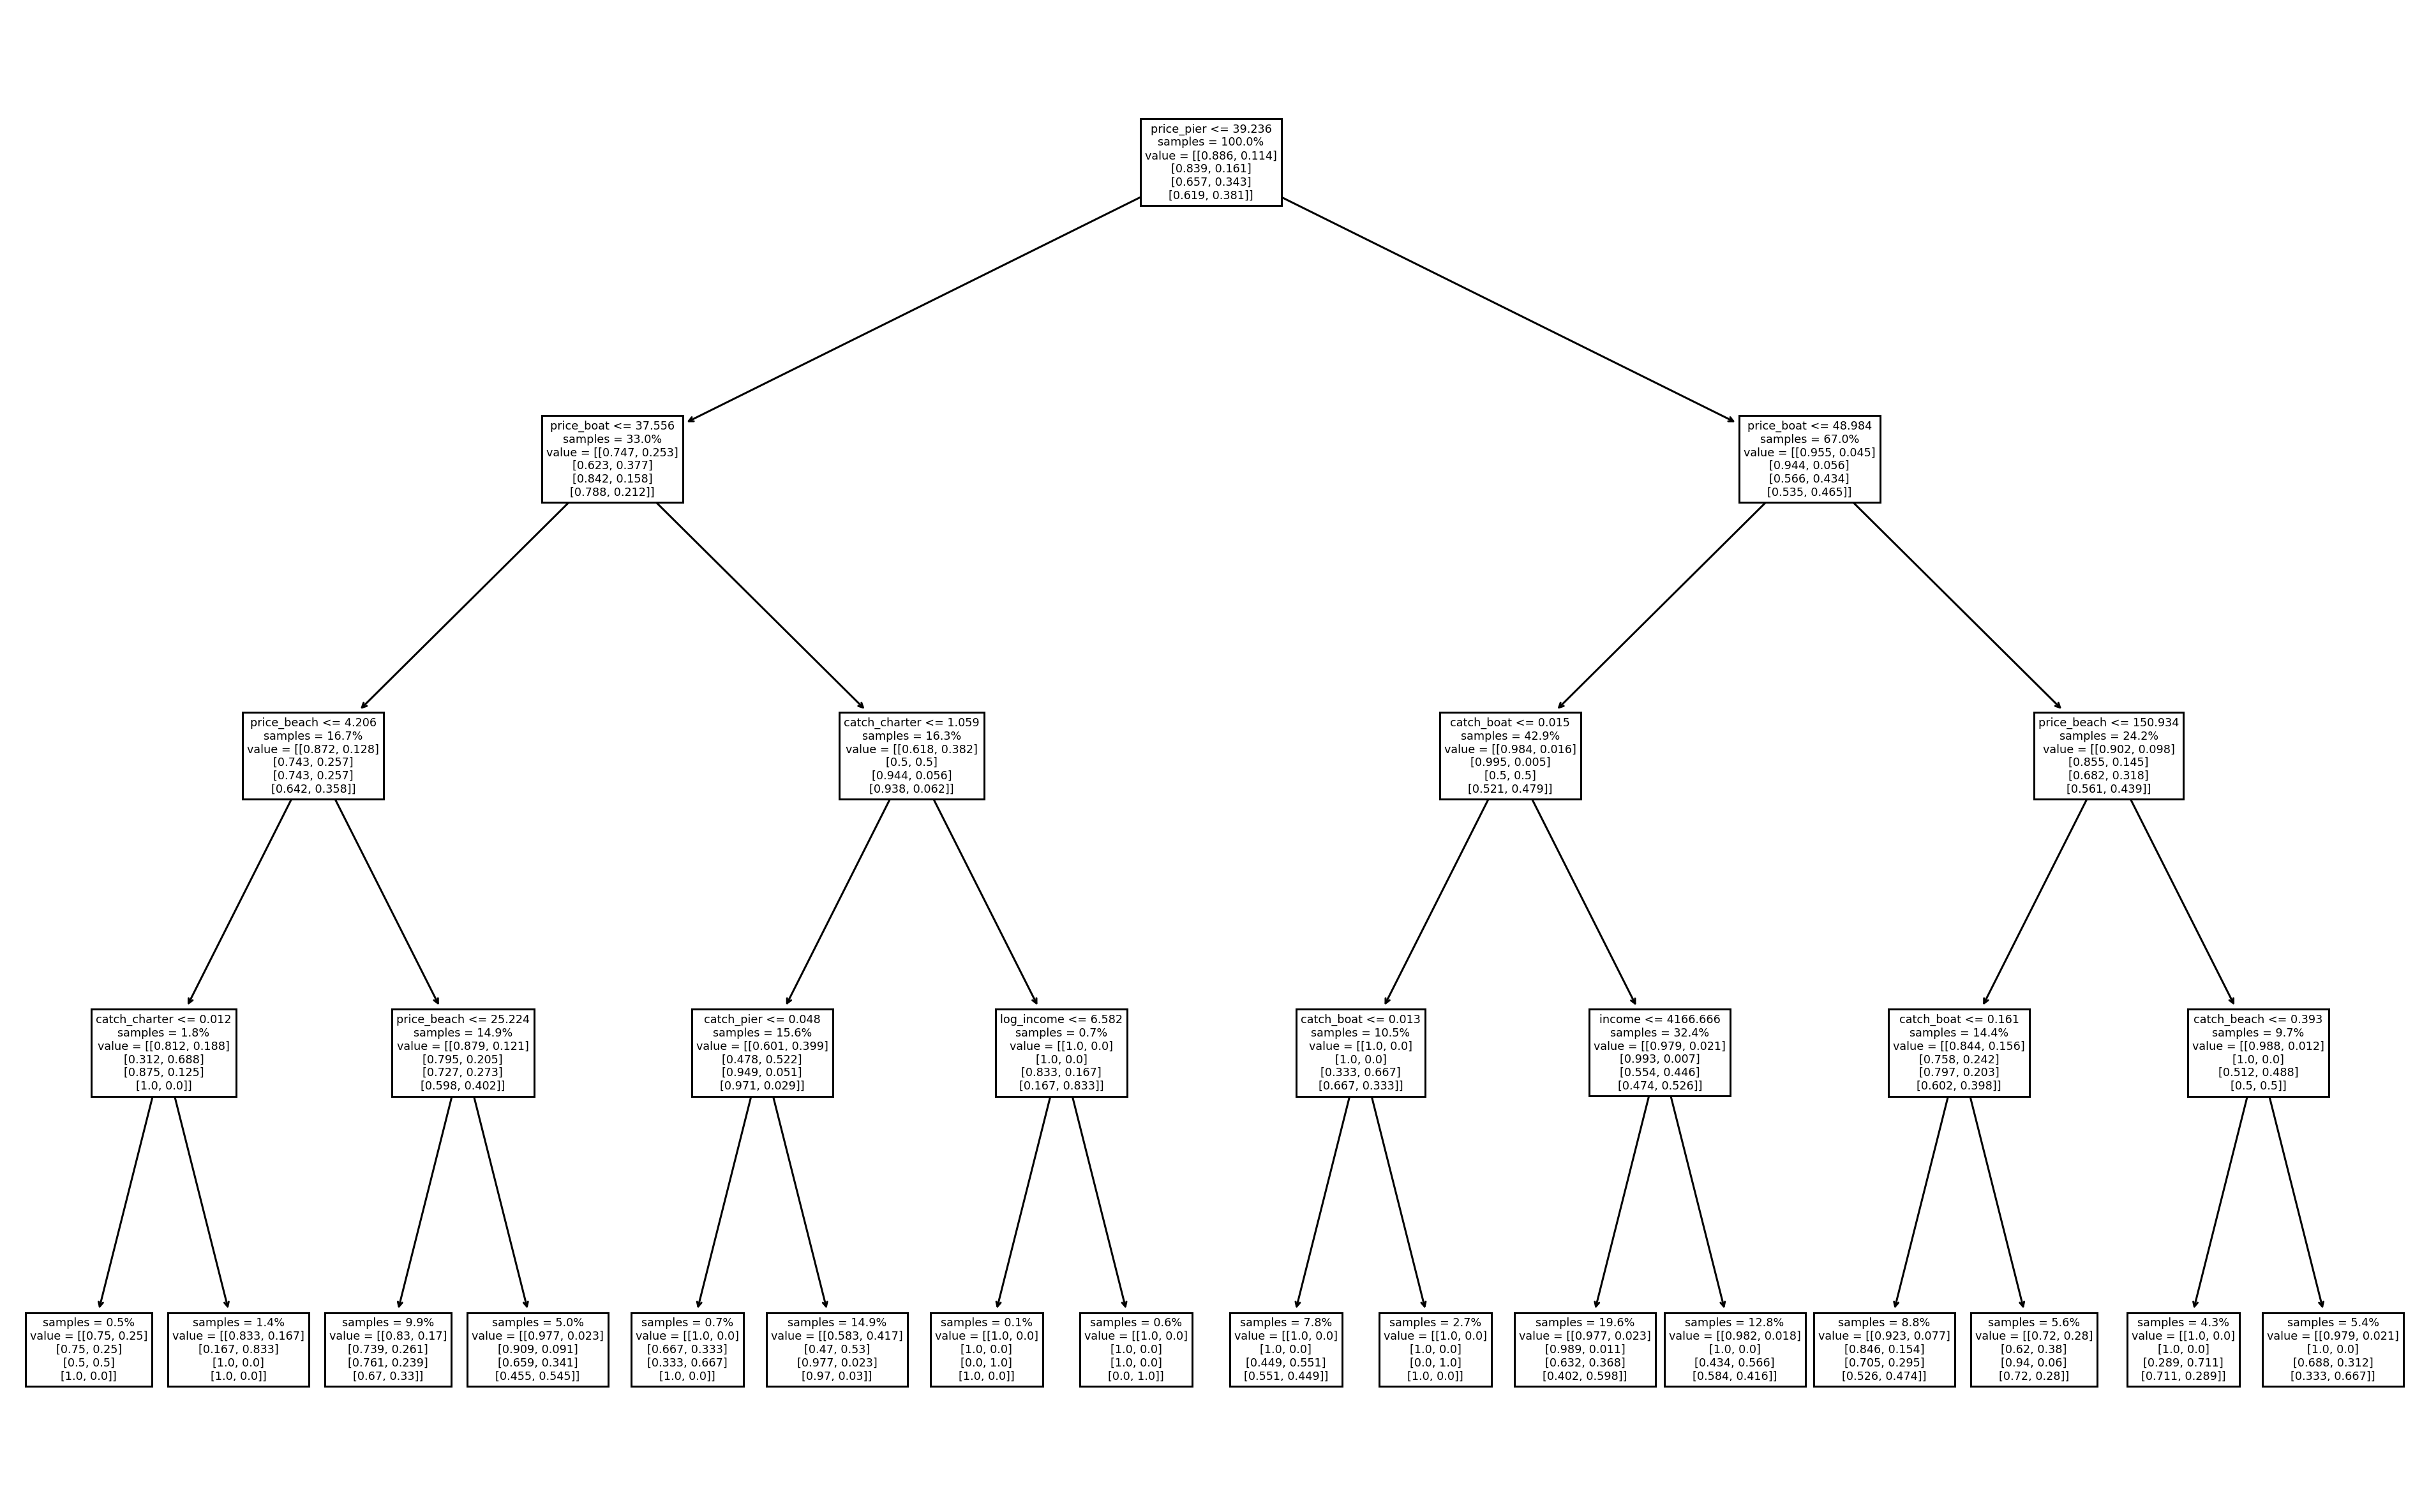

In [38]:
from sklearn import tree
fig=plt.figure(figsize=(22,14), dpi= 220)
treeplot = tree.plot_tree(dec_tree, feature_names= fish_adv_test.drop('mode', axis=1).columns,
                          class_names = ['beach', 'pier', 'private boat', 'charter boat'],
                          label = 'all',
                          impurity=False,
                          proportion=True)

# Neural network model



To use a simple neural network model, the multi layer preceptron, we can also 
use the implementation in the `sklearn` package, `MLPClassifier`. There are a few arguments to it, the more important is the size of the hidden layers. We wil use only one layer at the beginning because of its connection to a latent class mixed logit.

The remaining of the code is the same as in the decision tree!

In [39]:
# Import the model we are using
from sklearn.neural_network import MLPClassifier


neurnet = MLPClassifier(hidden_layer_sizes = (500),
                        activation='logistic',  max_iter=12000, random_state=3840)

In [40]:

# Train the model on training data
neurnet.fit(fish_adv_train.drop('mode', axis=1), pd.get_dummies(fish_adv_train['mode']));

In [41]:
# Use the forest's predict method on the test data
predictions = neurnet.predict(fish_adv_test.drop('mode', axis=1))

neurnet_sim = pd.DataFrame(predictions, columns=[1, 2, 3, 4])

In [42]:
neurnet_sim.head(5)

,1,2,3,4
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1


In [43]:
neurnet_sim.index = fish_adv_test.index

In [44]:
qbus_calc_accu_confusion(neurnet_sim, fish_adv_test, 'mode')

(0.41216216216216217, Predicted   1   2   3   4
 Actual                   
 1          26   7   0   0
 2          22  11   0   2
 3          32   1  49  32
 4          36   0  42  36)

# Exercise: Try a baseline multinomial logit, decision tree and multilayer perceptron models on the Swismetro dataset and compare the results.

Load the daaset as usual

In [45]:
swissmetro = pd.read_csv('http://transp-or.epfl.ch/data/swissmetro.dat', sep='\t')

Clean the dataset as instructed in Biogeme's example

In [46]:
swissmetro = swissmetro.loc[ swissmetro['CHOICE'] != 0, :]
swissmetro['TRAIN_CO_GA'] = swissmetro['TRAIN_CO'] * (swissmetro['GA'] ==0 )
swissmetro['SM_CO_GA'] = swissmetro['SM_CO'] * (swissmetro['GA'] ==0 )

We additionally remove some of the variables that shold not be used by the model, for example the availabilities (which are not real observable variables in a real situation) and 'ID' which identies the individuals.

In [ ]:
swissmetro = swissmetro.drop(['TRAIN_AV', 'SM_AV', 'CAR_AV', 'ID'], axis=1)

Fit a base MNL model

In [47]:
qbus_update_globals_bgm(swissmetro)

In [48]:
sw_train, sw_test = train_test_split(swissmetro, test_size = 0.25, random_state = 3840)

In [49]:
ASC_CAR = exp.Beta ( 'ASC_CAR' ,0, None , None ,0)
ASC_TRAIN = exp.Beta ( 'ASC_TRAIN' ,0, None , None ,0)
ASC_SM = exp.Beta ( 'ASC_SM' ,0, None , None ,1)
B_TIME = exp.Beta ( 'B_TIME' ,0, None , None ,0)
B_COST = exp.Beta ( 'B_COST' ,0, None , None ,0)
B_MALE_TR = exp.Beta( 'B_MALE_TR', 0, None, None, 0)
B_MALE_SM = exp.Beta( 'B_MALE_SM', 0, None, None, 0)
B_MALE_CAR = exp.Beta( 'B_MALE_CAR', 0, None, None, 0)
B_INCOME_TR = exp.Beta( 'B_INCOME_TR', 0, None, None, 0)
B_INCOME_SM = exp.Beta( 'B_INCOME_SM', 0, None, None, 0)
B_INCOME_CAR = exp.Beta( 'B_INCOME_CAR', 0, None, None, 0)

V1 = ASC_TRAIN + B_TIME * TRAIN_TT + B_COST * TRAIN_CO_GA + B_MALE_TR*MALE + B_INCOME_TR*INCOME
V2 = ASC_SM + B_TIME * SM_TT + B_COST * SM_CO_GA + B_MALE_SM*MALE + B_INCOME_SM*INCOME
V3 = ASC_CAR + B_TIME * CAR_TT + B_COST * CAR_CO + B_MALE_CAR*MALE+ B_INCOME_CAR*INCOME

V_sw = {1: V1, 2:V2, 3:V3}

In [50]:
model_sw, results_sw = qbus_estimate_bgm(V_sw, sw_train, 'CHOICE', 'swismmetro_mnl')

In [51]:
results_sw.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-1.256416,0.086795,-14.475633,0.000000,0.089056,-14.108160,0.000000
ASC_TRAIN,-0.428556,0.092994,-4.608436,0.000004,0.097510,-4.394984,0.000011
B_COST,-0.004257,0.000328,-12.989321,0.000000,0.000360,-11.837229,0.000000
B_INCOME_CAR,0.052416,0.019507,2.687066,0.007208,0.019964,2.625556,0.008651
B_INCOME_SM,0.024673,0.016702,1.477177,0.139628,0.017415,1.416744,0.156558
B_INCOME_TR,-0.077089,0.022958,-3.357755,0.000786,0.026131,-2.950100,0.003177
B_MALE_CAR,0.711854,0.045574,15.619811,0.000000,0.048760,14.599169,0.000000
B_MALE_SM,0.083666,0.036766,2.275605,0.022870,0.037668,2.221128,0.026342
B_MALE_TR,-0.795520,0.046589,-17.075403,0.000000,0.048016,-16.567714,0.000000
B_TIME,-0.003403,0.000332,-10.246474,0.000000,0.000358,-9.497852,0.000000


Accuracy in the train set

In [52]:
sw_train_sim = qbus_simulate_bgm(model_sw, results_sw.getBetaValues(), sw_train)
qbus_calc_accu_confusion(sw_train_sim, sw_train, 'CHOICE')

(0.5610150516233362, Predicted     2    3
 Actual              
 1          1023   80
 2          4411  215
 3          2211   99)

Accuracy in the test set

In [53]:
sw_test_sim = qbus_simulate_bgm(model_sw, results_sw.getBetaValues(), sw_test)
qbus_calc_accu_confusion(sw_test_sim, sw_test, 'CHOICE')

(0.5809701492537314, Predicted     2   3
 Actual             
 1           290  30
 2          1517  73
 3           730  40)

#Decision tree

In [54]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Instantiate model with 1000 decision trees
#dec_tree = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features= None)

dec_tree = DecisionTreeClassifier(max_features= None, max_depth=14, random_state=3840 )

In [55]:
dec_tree.fit(sw_train.drop('CHOICE', axis=1), pd.get_dummies(sw_train['CHOICE']));

In [56]:
# Use the predict method on the test data
predictions = dec_tree.predict(sw_test.drop('CHOICE', axis=1))
predictions

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [57]:
dec_tree_sim = pd.DataFrame(predictions, columns=[1, 2, 3])

In [58]:
dec_tree_sim.index = sw_test.index

And finally, we can compute the accuracy, we see that is considerably higher thatn the MNL model

In [59]:
qbus_calc_accu_confusion(dec_tree_sim, sw_test, 'CHOICE')

(0.7126865671641791, Predicted    1     2    3
 Actual                   
 1          194   115   11
 2          160  1214  216
 3           34   234  502)

# Neural Network

In [60]:
from sklearn.neural_network import MLPClassifier

neurnet = MLPClassifier(hidden_layer_sizes = (256),
                        activation='logistic',  max_iter=12000, random_state=3840)

In [61]:
neurnet.fit(sw_train.drop('CHOICE', axis=1), pd.get_dummies(sw_train['CHOICE']));

In [62]:
sw_test = sw_train

In [63]:
# Use the predict method on the test data
predictions = neurnet.predict(sw_test.drop('CHOICE', axis=1))
predictions

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [64]:
neurnet_sim = pd.DataFrame(predictions, columns=[1, 2, 3])

In [65]:
neurnet_sim.index = sw_test.index

The accuracy of the neural network is also higher than the MNL (but remember that is is a special case of mixed logit!)

In [66]:
qbus_calc_accu_confusion(neurnet_sim, sw_test, 'CHOICE')

(0.73168304515487, Predicted    1     2     3
 Actual                    
 1          789   264    50
 2          590  3415   621
 3          205   427  1678)